In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
all_data_predict = {}
for L in [16, 32, 48, 64]:
    with open(f'plot_data/macro_L_{L}.pkl', 'rb') as f:
        data = pickle.load(f)
    all_data_predict[f'L{L}'] = data

In [3]:
# Estimate the slope of U vs T at T_c = 2.269 using curve fitting
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

T_c = 2.269
slopes_at_Tc = {}

# Define polynomial functions for fitting
def linear_func(T, a, b):
    """Linear function"""
    return a*T + b

def linear_derivative(T, a, b):
    """Derivative of linear function"""
    return a

def polynomial_func(T, a, b, c, d):
    """Cubic polynomial function"""
    return a*T**3 + b*T**2 + c*T + d

def polynomial_derivative(T, a, b, c, d):
    """Derivative of cubic polynomial"""
    return 3*a*T**2 + 2*b*T + c

T_smooth_dict = {}
U_smooth_dict = {}
T_tangent_dict = {}
U_tangent_dict = {}

# Plot 1: Binder cumulant vs Temperature with fitted curves
for system_size, data in all_data_predict.items():

    T = data['T']
    U = data['U']
    L = int(system_size[1:])  # Extract L value
    
    # Choose fitting method based on system size
    if L == 16:
        # Use linear fitting for L=16
        if len(T) >= 2:  # Need at least 2 points for linear fit
            try:
                # Linear fitting
                popt, _ = curve_fit(linear_func, T, U)
                
                # Generate smooth curve for plotting
                T_smooth = np.linspace(T.min(), T.max(), 200)
                U_smooth = linear_func(T_smooth, *popt)

                T_smooth_dict[system_size] = T_smooth
                U_smooth_dict[system_size] = U_smooth
                
                # Calculate slope at T_c (constant for linear)
                slope_at_Tc = linear_derivative(T_c, *popt)
                slopes_at_Tc[system_size] = slope_at_Tc
                
                print(f"System Size {system_size}: Slope dU/dT at T_c ≈ {slope_at_Tc:.4f} (linear fit)")
                
                # Plot tangent line at T_c
                T_tangent = np.linspace(T_c - 0.008, T_c + 0.008, 100)
                U_at_Tc = linear_func(T_c, *popt)
                U_tangent = U_at_Tc + slope_at_Tc * (T_tangent - T_c)

                T_tangent_dict[system_size] = T_tangent
                U_tangent_dict[system_size] = U_tangent
                
            except Exception as e:
                print(f"Could not fit {system_size} with linear: {e}")
    else:
        # Use cubic fitting for other system sizes
        if len(T) >= 4:  # Need at least 4 points for cubic fit
            
            # Method 1: Polynomial fitting (cubic)
            popt, _ = curve_fit(polynomial_func, T, U)
            
            # Generate smooth curve for plotting
            T_smooth = np.linspace(T.min(), T.max(), 200)
            U_smooth = polynomial_func(T_smooth, *popt)

            T_smooth_dict[system_size] = T_smooth
            U_smooth_dict[system_size] = U_smooth            
            # Calculate slope at T_c
            slope_at_Tc = polynomial_derivative(T_c, *popt)
            slopes_at_Tc[system_size] = slope_at_Tc
            
            print(f"System Size {system_size}: Slope dU/dT at T_c ≈ {slope_at_Tc:.4f} (cubic fit)")
            
            # Plot tangent line at T_c
            T_tangent = np.linspace(T_c - 0.008, T_c + 0.008, 100)
            U_at_Tc = polynomial_func(T_c, *popt)
            U_tangent = U_at_Tc + slope_at_Tc * (T_tangent - T_c)
            T_tangent_dict[system_size] = T_tangent
            U_tangent_dict[system_size] = U_tangent
        

# Plot 2: Slope vs System Size
if slopes_at_Tc:
    system_sizes = [int(size[1:]) for size in slopes_at_Tc.keys()]  # Extract L values
    slopes = list(slopes_at_Tc.values())
    
    log_L = np.log(system_sizes)
    log_slope_abs = np.log(np.abs(slopes))
    coeffs = np.polyfit(log_L, log_slope_abs, 1)
    exponent = coeffs[0]
    log_A = coeffs[1]
    
    # Plot the power law fit
    L_fit = np.linspace(min(system_sizes), max(system_sizes), 100)
    slope_fit = np.exp(log_A) * L_fit**exponent  # positive for absolute values    
    print(f"\nPower law scaling: |slope| ∝ L^{exponent:.4f}")
    
    # Print summary
    print(f"\nSummary of slopes at T_c = {T_c} (from curve fitting):")
    for size, slope in slopes_at_Tc.items():
        L = int(size[1:])
        fit_type = "linear" if L == 16 else "cubic"
        print(f"{size}: {slope:.6f} ({fit_type} fit)")
    
    print(f"\nMean slope: {np.mean(slopes):.6f} ± {np.std(slopes):.6f}")

System Size L16: Slope dU/dT at T_c ≈ -0.6307 (linear fit)
System Size L32: Slope dU/dT at T_c ≈ -1.2823 (cubic fit)
System Size L48: Slope dU/dT at T_c ≈ -1.8304 (cubic fit)
System Size L64: Slope dU/dT at T_c ≈ -2.8442 (cubic fit)

Power law scaling: |slope| ∝ L^1.0546

Summary of slopes at T_c = 2.269 (from curve fitting):
L16: -0.630678 (linear fit)
L32: -1.282338 (cubic fit)
L48: -1.830427 (cubic fit)
L64: -2.844180 (cubic fit)

Mean slope: -1.646906 ± 0.811291


In [4]:
# Load the saved results
with open('plot_data/M_equilibrium_T_2.27.pkl', 'rb') as f:
    M_equilibrium = pickle.load(f)

with open('plot_data/M_predict_T_2.27.pkl', 'rb') as f:
    M_predict = pickle.load(f)

print("Successfully loaded the results!")
print("M_equilibrium keys:", list(M_equilibrium.keys()))
print("M_predict keys:", list(M_predict.keys()))

Successfully loaded the results!
M_equilibrium keys: ['L16', 'L32', 'L64', 'L128']
M_predict keys: ['L16', 'L32', 'L64', 'L128']


In [5]:
M_true = []
X_true = []
M_pred = []
X_pred = []

def cal_mag_susceptibility(M, L, T=2.27):
    M = np.abs(M)  
    mag_susceptibility = np.mean(M ** 2) - np.mean(M) ** 2
    mag_susceptibility = mag_susceptibility * L ** 2 / T 
    return mag_susceptibility

L_list = [16, 32, 64, 128]

for L in L_list:
    M_equilibrium_array = M_equilibrium[f'L{L}']
    M = np.mean(M_equilibrium_array)
    X = cal_mag_susceptibility(M_equilibrium_array, L)
    M_true.append(M)
    X_true.append(X)
    # print('#'*20, f'L = {L}, box_L = 16', '#'*20)
    # print('ground truth magnetization:', M)
    # print('ground truth Magnetic susceptibility:', X)

    M_list = []
    X_list = []
    M_predict_array = M_predict[f'L{L}']
    for M_predict_array in M_predict[f'L{L}']:

        M = np.mean(M_predict_array)
        X = cal_mag_susceptibility(M_predict_array, L)
        M_list.append(M)
        X_list.append(X)
    # print('M_list:', M_list)
    # print('X_list:', X_list)
    
    M_mean = np.mean(M_list)
    X_mean = np.mean(X_list)
    M_pred.append(M_mean)
    X_pred.append(X_mean)
    # print('Predicted Mean magnetization:', M_mean)
    # print('Predicted Magnetic susceptibility:', X_mean)

L_list = [16, 32, 64, 128]
L_list = np.array(L_list)
M_true = np.array(M_true)
X_true = np.array(X_true)
M_pred = np.array(M_pred)
X_pred = np.array(X_pred)

In [6]:
coeffs = np.polyfit(np.log(L_list), np.log(M_pred), 1)
kappa_nu_log = coeffs[0]
log_A_log = coeffs[1]
A_log = np.exp(log_A_log)

# Calculate correlation coefficient
correlation_matrix = np.corrcoef(np.log(L_list), np.log(M_pred))
r_correlation = correlation_matrix[0, 1]
r_squared_log = r_correlation ** 2

print(f"\nAlternative method (linear fit in log space):")
print(f"κ/ν = {kappa_nu_log:.6f}")
print(f"A = {A_log:.6f}")
print(f"R² = {r_squared_log:.6f}")
log_L_fit = np.linspace(np.log(L_list).min(), np.log(L_list).max(), 100)
y_M = kappa_nu_log * log_L_fit + log_A_log


Alternative method (linear fit in log space):
κ/ν = -0.119925
A = 0.990608
R² = 0.975532


In [7]:
# Linear fit in log space
# log(X) = log(A) + (κ/ν) * log(L)
# Linear fit: y = mx + b where y = log(X), x = log(L), m = κ/ν, b = log(A)
coeffs = np.polyfit(np.log(L_list), np.log(X_pred), 1)
kappa_nu_log = coeffs[0]
log_A_log = coeffs[1]
A_log = np.exp(log_A_log)

# Calculate correlation coefficient
correlation_matrix = np.corrcoef(np.log(L_list), np.log(X_pred))
r_correlation = correlation_matrix[0, 1]
r_squared_log = r_correlation ** 2

print(f"\nAlternative method (linear fit in log space):")
print(f"κ/ν = {kappa_nu_log:.6f}")
print(f"A = {A_log:.6f}")
print(f"R² = {r_squared_log:.6f}")
log_L_fit = np.linspace(np.log(L_list).min(), np.log(L_list).max(), 100)
y_X = kappa_nu_log * log_L_fit + log_A_log


Alternative method (linear fit in log space):
κ/ν = 1.791777
A = 0.027312
R² = 0.997775


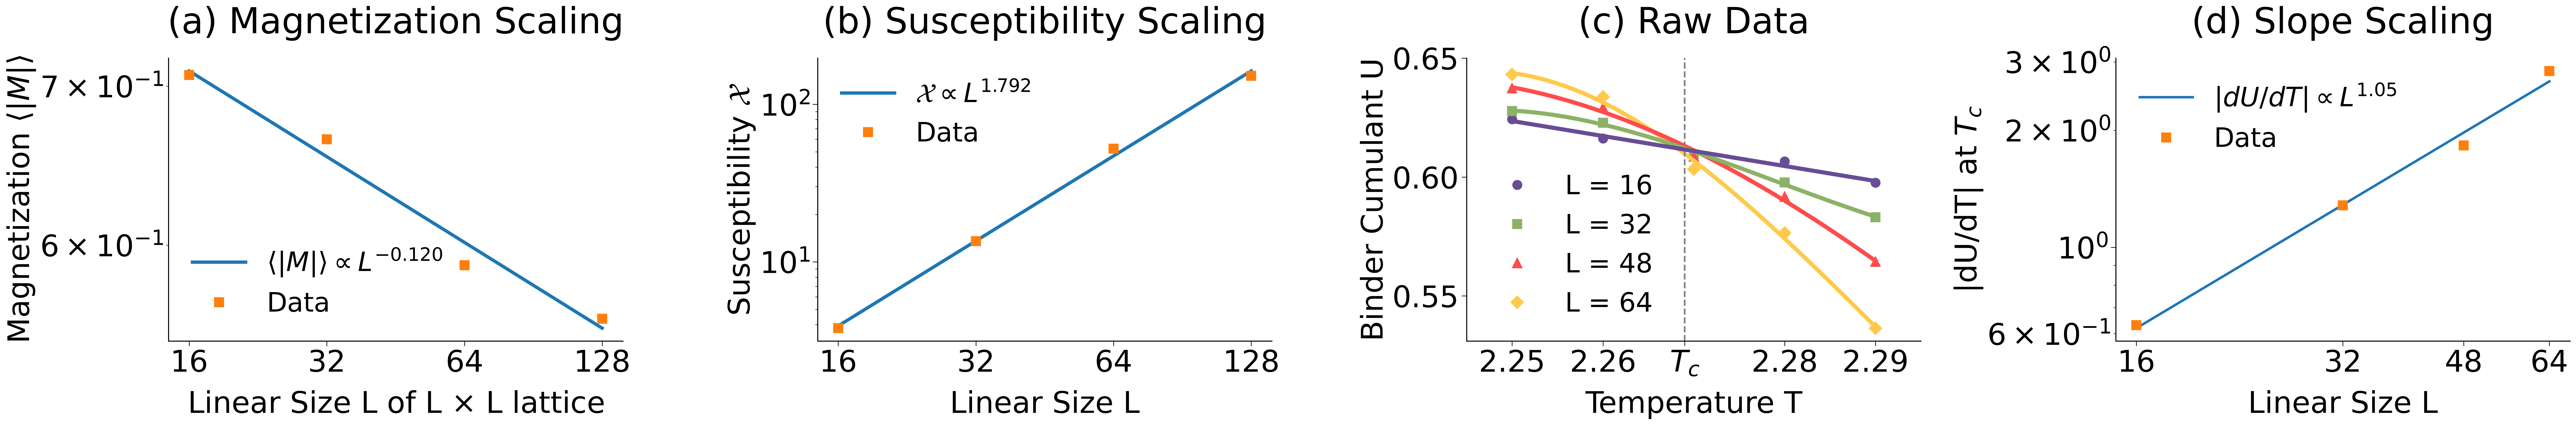

In [8]:
# ========== Enhanced Academic Visualization for Ablation Study ==============
from cProfile import label
import matplotlib.patches as mpatches
from matplotlib.ticker import FixedLocator, FixedFormatter

# Set up professional academic figure style
plt.rcParams.update({
    'font.size': 36,
    'font.family': 'sans-serif',
    'text.usetex': False,  # Set to True if LaTeX is available
    'axes.linewidth': 1.2,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'xtick.minor.size': 3,
    'ytick.minor.size': 3,
    'legend.fontsize': 32,
    'legend.frameon': False,
})
# Define academic color scheme
colors = ['#684D94', '#8CB266','#FF4C4C', '#FFCA4C']  # Blue, Orange, Green, Red
markers = ['o', 's', '^', 'D']
linestyles = ['-', '-', '-', '-']

# Create figure with proper academic dimensions
fig = plt.figure(figsize=(44, 8), dpi=300, facecolor='white')
axes1 = fig.add_subplot(1, 4, 1)
axes1.set_yscale('log')
axes1.set_xscale('log')

# Plot magnetic susceptibility, not magnetization
axes1.plot(np.exp(log_L_fit), np.exp(y_M), '-', c='tab:blue', linewidth=4, 
         label=r'$\langle |M| \rangle \propto L^{-0.120}$')
axes1.plot(L_list, M_pred, 's', c='tab:orange', markersize=10, 
           label='Data', markeredgewidth=2)
axes1.set_xlabel(r'Linear Size L of L $\times$ L lattice', labelpad=15)
axes1.set_ylabel(r'Magnetization $\langle |M| \rangle$')
axes1.set_title(r'(a) Magnetization Scaling', pad=30)
# axes1.set_xlim(1,)
axes1.legend(loc='lower left')
axes1.xaxis.set_major_locator(FixedLocator([16, 32, 64, 128]))
axes1.xaxis.set_major_formatter(FixedFormatter(['16', '32', '64', '128']))
axes1.xaxis.set_minor_locator(FixedLocator([]))  # No minor ticks
axes1.tick_params(axis='x', which='minor', bottom=False, top=False)


axes2 = fig.add_subplot(1, 4, 2)
axes2.set_yscale('log')
axes2.set_xscale('log')

axes2.plot(np.exp(log_L_fit), np.exp(y_X), '-', c='tab:blue', linewidth=4, 
         label=r'$\mathcal{X} \propto L^{1.792}$')
axes2.plot(L_list, X_pred, 's', c='tab:orange', markersize=10, 
           label='Data', markeredgewidth=2)

axes2.set_xlabel(r'Linear Size L', labelpad=15)
axes2.set_ylabel(r'Susceptibility $\mathcal{X}$')
axes2.set_title(r'(b) Susceptibility Scaling', pad=30)
axes2.legend(loc='upper left')
axes2.xaxis.set_major_locator(FixedLocator([16, 32, 64, 128]))
axes2.xaxis.set_major_formatter(FixedFormatter(['16', '32', '64', '128']))
axes2.xaxis.set_minor_locator(FixedLocator([]))  # No minor ticks
axes2.tick_params(axis='x', which='minor', bottom=False, top=False)


axes3 = fig.add_subplot(1, 4, 3)

for i, (system_size, data) in enumerate(all_data_predict.items()):
    T = data['T']
    U = data['U']
    L = int(system_size[1:])  # Extract L value
    axes3.plot(T, U, markers[i], color=colors[i], label=f'L = {L}', markersize=10, markeredgewidth=2)
    
    T_smooth = T_smooth_dict[system_size]
    U_smooth = U_smooth_dict[system_size]
    axes3.plot(T_smooth, U_smooth, linestyles[i], color=colors[i], linewidth=5, zorder=5-i)

axes3.axvline(x=T_c, color='gray', linestyle='--', linewidth=2, alpha=1)
axes3.set_xlabel('Temperature T', labelpad=15)
axes3.set_ylabel('Binder Cumulant U')
axes3.set_title('(c) Raw Data', pad=30)
axes3.legend(loc='lower left')
axes3.set_yticks([0.55, 0.60, 0.65])

# Add T_c marker to x-axis
# current_xticks = list(axes3.get_xticks())
# current_xticks.append(T_c)
current_xticks = [2.25, 2.26, T_c, 2.28, 2.29]
current_xticks.sort()
axes3.set_xticks(current_xticks)

# Create custom x-tick labels with T_c marked
xtick_labels = []
for tick in current_xticks:
    if abs(tick - T_c) < 0.001:  # Check if this tick is T_c
        xtick_labels.append('$T_c$')
    else:
        xtick_labels.append(f'{tick:.2f}')
axes3.set_xticklabels(xtick_labels)
axes3.set_xlim(2.245, 2.295)


system_sizes = [int(size[1:]) for size in slopes_at_Tc.keys()]  # Extract L values
slopes = list(slopes_at_Tc.values())

axes4 = fig.add_subplot(1, 4, 4)
axes4.plot(L_fit, slope_fit, '-', linewidth=3, label=r'$|dU/dT| \propto L^{1.05}$', color='tab:blue')
axes4.plot(system_sizes, np.abs(slopes), 's', markersize=10,  
        markeredgewidth=2, color='tab:orange', label='Data')
axes4.set_xlabel('Linear Size L', labelpad=15)
axes4.set_ylabel('|dU/dT| at $T_c$')
axes4.set_title('(d) Slope Scaling', pad=30)

axes4.set_xscale('log')
axes4.set_yscale('log')

# Completely override x-axis tick generation
from matplotlib.ticker import FixedLocator, FixedFormatter
axes4.xaxis.set_major_locator(FixedLocator([16, 32, 48, 64]))
axes4.xaxis.set_major_formatter(FixedFormatter(['16', '32', '48', '64']))
axes4.xaxis.set_minor_locator(FixedLocator([]))  # No minor ticks
axes4.tick_params(axis='x', which='minor', bottom=False, top=False)

axes4.legend()


# Tight layout for proper spacing
plt.tight_layout()
# plt.tight_layout(pad=8, w_pad=0.2, h_pad=0.2)
plt.savefig('Ising_scaling.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.savefig('Ising_scaling.pdf', bbox_inches='tight', 
            facecolor='white', edgecolor='none')

# Display the plot
plt.show()

### finite Size Scaling Analysis

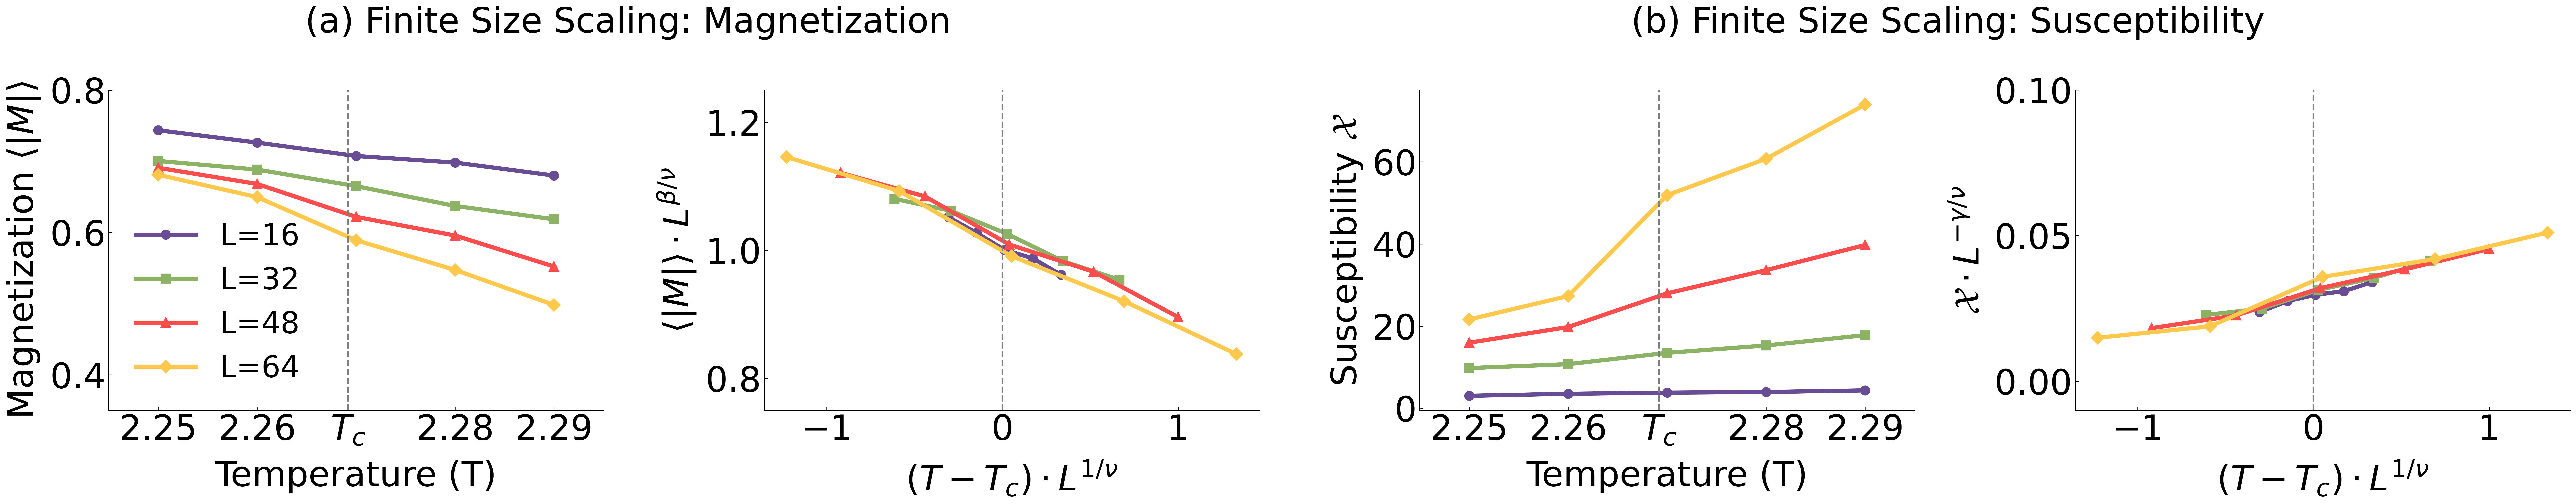

In [9]:
plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams.update({
    'font.size': 42,
    'font.family': 'sans-serif', 
    'text.usetex': False,  # Set to True if LaTeX is available
    'axes.linewidth': 1.2,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.minor.size': 2,
    'ytick.minor.size': 2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'legend.frameon': False,
    'legend.fontsize': 36,
})
T_c = 2 / (np.log(1 + np.sqrt(2)))
current_xticks = [2.25, 2.26, T_c, 2.28, 2.29]
current_xticks.sort()
# Create custom x-tick labels with T_c marked
xtick_labels = []
for tick in current_xticks:
    if abs(tick - T_c) < 0.001:  # Check if this tick is T_c
        xtick_labels.append('$T_c$')
    else:
        xtick_labels.append(f'{tick:.2f}')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(44, 9), dpi=300)

beta_nu = 1/8  # β/ν for magnetization  
gamma_nu = 7/4  # γ/ν for susceptibility
one_nu = 1     # 1/ν

colors = ['#684D94', '#8CB266','#FF4C4C', '#FFCA4C']  # Blue, Orange, Green, Red
markers = ['o', 's', '^', 'D']

# Plot 1: Raw magnetization data
for i, (system_size, data) in enumerate(all_data_predict.items()):
    L = int(system_size[1:])
    T = data['T']
    M = data['M']
    ax1.plot(T, M, markers[i] + '-', color=colors[i], markersize=10, markeredgewidth=2, label=f'L={L}', linewidth=5)

ax1.axvline(x=T_c, color='gray', linestyle='--', linewidth=2, alpha=1)
ax1.set_xlabel('Temperature (T)', labelpad=15)
ax1.set_ylabel(r'Magnetization $\langle |M| \rangle$', labelpad=10)
# ax1.set_title('(a) Raw Magnetization Data', pad=30)
ax1.legend()
ax1.set_ylim(0.35, 0.8)
# ax1.set_yticks([0.5, 0.6, 0.7])
ax1.set_xticks(current_xticks)
ax1.set_xticklabels(xtick_labels)
ax1.set_xlim(2.245, 2.295)


# Plot 2: Corrected magnetization finite size scaling

for i, (system_size, data) in enumerate(all_data_predict.items()):
    L = int(system_size[1:])
    T = data['T']
    M = data['M']

    x_scaled = (T - T_c) * (L ** one_nu)
    y_scaled = M * (L ** beta_nu)
    
    ax2.plot(x_scaled, y_scaled, markers[i] + '-', color=colors[i], 
             markersize=10, label=f'L={L}', linewidth=5, markeredgewidth=2)

ax2.axvline(x=0, color='gray', linestyle='--', linewidth=2, alpha=1)
ax2.set_xlabel(r'$(T - T_c) \cdot L^{1/\nu}$', labelpad=15)
ax2.set_ylabel(r'$\langle |M| \rangle \cdot L^{\beta/\nu}$', labelpad=10)
# ax2.set_title(r'(b) Finite Size Scaling: $\langle |M| \rangle$', pad=30)
ax2.set_ylim(0.75, 1.25)

# Plot 3: Raw susceptibility data  
for i, (system_size, data) in enumerate(all_data_predict.items()):
    L = int(system_size[1:])
    T = data['T']
    X = data['X']
    ax3.plot(T, X, markers[i] + '-', color=colors[i], markersize=10, markeredgewidth=2, label=f'L={L}', linewidth=5)

ax3.axvline(x=T_c, color='gray', linestyle='--', linewidth=2, alpha=1)
ax3.set_xlabel('Temperature (T)', labelpad=15)
ax3.set_ylabel(r'Susceptibility $\mathcal{X}$', labelpad=10)
# ax3.set_title('(c) Raw Susceptibility Data', pad=30)
# ax2.set_yscale('log')

ax3.set_xticks(current_xticks)
ax3.set_xticklabels(xtick_labels)
ax3.set_xlim(2.245, 2.295)

# Plot 4: Corrected susceptibility finite size scaling
for i, (system_size, data) in enumerate(all_data_predict.items()):
    L = int(system_size[1:])
    T = data['T']
    X = data['X']
    

    # Calculate finite size scaling variables
    x_scaled = (T - T_c) * (L ** one_nu)
    y_scaled = X * (L ** (-gamma_nu))
    
    ax4.plot(x_scaled, y_scaled, markers[i] + '-', color=colors[i], 
             markersize=10, label=f'L={L}', linewidth=5, markeredgewidth=2)

ax4.axvline(x=0, color='gray', linestyle='--', linewidth=2, alpha=1, label='$T = T_c$')
ax4.set_xlabel(r'$(T - T_c) \cdot L^{1/\nu}$', labelpad=15)
ax4.set_ylabel(r'$\mathcal{X} \cdot L^{-\gamma/\nu}$', labelpad=10)
# ax4.set_title(r'(d) Finite Size Scaling: $\mathcal{X}$', pad=30)
ax4.set_ylim(-0.01, 0.1)
ax4.set_yticks([0, 0.05, 0.10])

# Add suptitles for each pair of subplots
# Suptitle for (a,b) - Magnetization
fig.text(0.25, 0.95, '(a) Finite Size Scaling: Magnetization', ha='center', va='center')

# Suptitle for (c,d) - Susceptibility  
fig.text(0.75, 0.95, '(b) Finite Size Scaling: Susceptibility', ha='center', va='center')

plt.tight_layout(rect=[0, 0, 1, 0.92])  # Leave space at top for suptitles
plt.savefig('finite_size_scaling.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.savefig('finite_size_scaling.pdf', bbox_inches='tight', 
            facecolor='white', edgecolor='none')

plt.show()